In [1]:
import matplotlib.pyplot as plt

import mygrad as mg
import numpy as np

%matplotlib notebook

# Training a Universal Function Approximator

The *universal approximation theorem* states:

Let $ \varphi (\cdot )$ be a nonconstant, bounded, and monotonically-increasing continuous function. Let $ I_m $ denote any compact subset of $ \mathbb {R} ^{m} $. The space of continuous functions $I_m  \mapsto \mathbb {R}$ is denoted by $C(I_{m})$. 

Then, given any $\varepsilon >0$ and any function $f\in C(I_{m})$, there exist $N$ real constants $v_{i},b_{i}\in \mathbb {R}$ and real vectors $\vec{w}_{i}\in \mathbb {R} ^{m}$, where $i=1,\cdots ,N$, such that we may define:

\begin{equation}
F(\{v_i\}, \{\vec{w}_i\}, \{b_i\}; \vec{x}) = \sum_{i=1}^{N} v_{i}\varphi(\vec{x} \cdot \vec{w}_{i} + b_{i})
\end{equation}

as an approximate realization of a function $f(x)$, where $f$ is independent of $\varphi$ ; that is,

\begin{equation}
| F( \vec{x} ) - f ( \vec{x} ) | < \varepsilon
\end{equation}

for all $ x\in I_{m}$. See that $\vec{x} \cdot \vec{w}_{i}$ is the dot product between $\vec{x}$ and $\vec{w}_{i}$, which are vectors in an $m$-dimensional space. Each ${b_i}$ is a scalar and each ${v_i}$ is a scalar. In later work we will want to extend $v_i$ to be a vector, so here we will also treat it as a vector in a 1-dimensional space, to make our future transition seamless.

This theorem was first proven in 1989, using the *sigmoid function* as $\varphi$:

\begin{equation}
\varphi(x) = \frac{1}{1 + e^{-x}}
\end{equation}



## Our problem
Here, we will try to find values for the parameters $N,v_{i},b_{i},w_{i}$  (where $i=1,\cdots ,N$) such that $F(x)$ approximates 

\begin{equation}
f(x) = \cos(x)\\
x \in [-2\pi, 2\pi]
\end{equation}

Using the sigmoid function as $\varphi$.

Because $\cos(x)$ maps $[-2\pi, 2\pi]  \mapsto [-1, 1]$, $x$ and $w_{i}$ are scalars. In the future we will be working with high dimensional data, so we will want to treat $x$ and $w_{i}$ as vectors in a 1-dimensional space (i.e. length-1 tensors) here; this will make it trivial to adapt our code to higher dimensional data later on.

We will search for optimal values of $v_{i},w_{i},b_{i}$ via *gradient descent*, using the obvious **loss function**:

\begin{equation}
L(\{v_i\}, \{w_i\}, \{b_i\}; x) = | F(\{v_i\}, \{w_i\}, \{b_i\}; x ) - \cos ( x ) |
\end{equation}

The *number* of parameters to use, $N$, is a **hyper parameter**, which we must find through trial and error, or some other means. $N$ is not something we can determine via gradient descent.


### Plotting our "activation function"

Import the `sigmoid` from `mygrad.nnet.activations`. Plot this function on the domain $[-10, 10]$. 

Is this a "nonconstant, bounded, and monotonically-increasing continuous function", as demanded for $\varphi$ by the universal approximation theorem?

What does the sigmoid function do to "extreme" values of $x$? What mechanism might this serve? Discuss with neighbors.

<IPython.core.display.Javascript object>


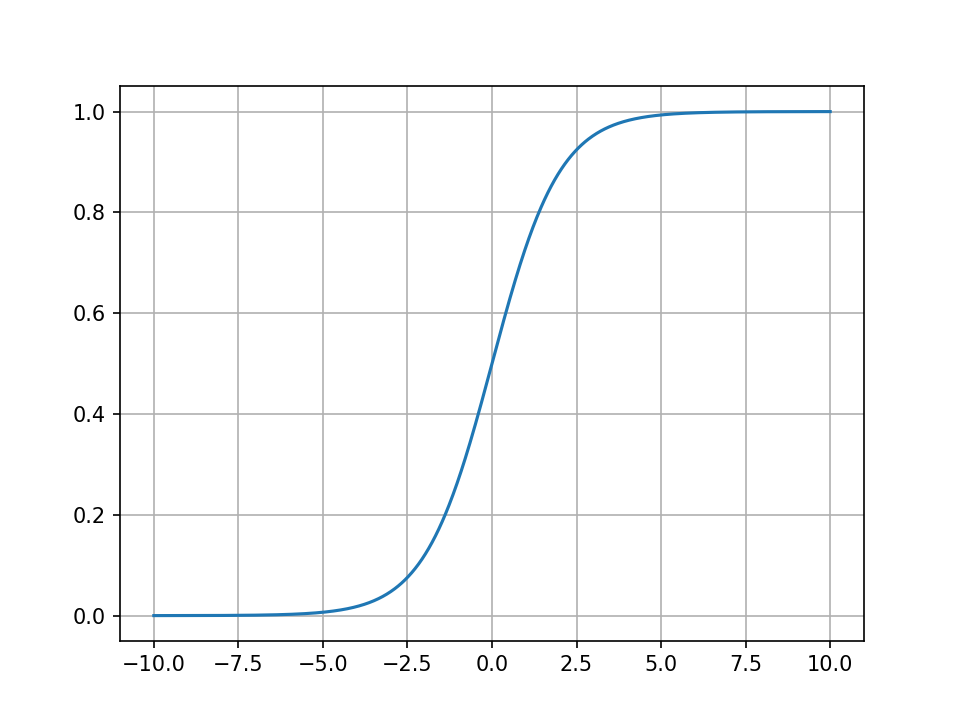

In [2]:
from mygrad.nnet.activations import sigmoid
fig, ax = plt.subplots()
x = np.linspace(-10, 10, 1000)
ax.plot(x, sigmoid(x))
ax.grid();


### Write a gradient-descent function
Write a gradient descent function that accepts a tuple of tensors and a **learning rate** ($\delta$). 

**For each tensor in a list/tuple**, update the tensor's *underlying numpy array* using to gradient descent. Skip the tensor if its gradient is `None`. Because you are modifying the data of these tensors in-place, this function need not return anything. Write a good docstring for the function.

In [3]:
def gradient_step(tensors, learning_rate):
    """
    Performs gradient-step in-place on each of the provides tensors 
    according to the standard formulation of gradient descent.

    Parameters
    ----------
    tensors : Union[Tensor, Iterable[Tensors]]
        A single tensor, or an iterable of an arbitrary number of tensors.

        If a `tensor.grad` is `None`for a specific tensor, the update on
        that tensor is skipped.

    learning_rate : float
        The "learning rate" factor for each descent step. A positive number.

    Notes
    -----
    The gradient-steps performed by this function occur in-place on each tensor,
    thus this function does not return anything
    """

    if isinstance(tensors, mg.Tensor):
        # Only one tensor was provided. Pack it into a list so it can be 
        # accessed via iteration
        tensors = [tensors]

    for t in tensors:
        if t.grad is not None:
            t.data -= learning_rate * t.grad


## Defining Our Model

<!-- #region -->
### Working with "Batches" of Data
It is computationally inefficient to train our model by passing it one datum, $x$, at a time. Rather, we will want to pass in a **batch** of $M$ pieces of input data, $\{x_{j}\}_{j=0}^{M-1}$, and evaluate our model for each of these values independently.  That is, we will pass on a batch of $M$ pieces of data and produce $M$ corresponding predictions from our model. 

Each prediction is made only on its corresponding piece of input data. Thus, prediction $F(\{v_i\}, \{w_i\}, \{b_i\}; x_j )$ depends only on:

- our model's parameters: $\{v_i\}, \{w_i\}, \{b_i\}$ 
- datum $x_j$

it is **not** impacted by any of the other pieces of data in the batch. This is very important to keep in mind!

We will make our $M$ predictions for the batch using vectorization and not for-loops. Thus `x` will be a shape-$(M, 1)$ numpy-array instead of a single number.

Recall that

\begin{equation}
x_j \cdot w_{i}
\end{equation}

can be evaluated all combinations of $j=1,\cdots ,M$ and $i=1,\cdots ,N$ via simple matrix multiplication between the shape-$(M, 1)$ `x` and the shape-$(1, N)$ `w`, producing a shape-$(M, N)$ output. And thus the following expression:

\begin{equation}
\varphi(x_{j} \cdot w_{i} + b_{i})
\end{equation}

can be performed for all $j$ and $i$ via broadcasting:

In [ ]:
sigmoid(mg.matmul(x, w) + b) # matmul[(M,1) w/ (1, N)] + (N,) --> (M, N)

<!-- #endregion -->

<!-- #region -->
Multiplying each such term by $v_{i}$ and summing over $i$ is thus just another matrix multiplication:

\begin{equation}
F(\{v_i\}, \{w_i\}, \{b_i\}; x_j ) = \sum_{i=1}^{N} v_{i}\varphi(x_{j} \cdot w_{i} + b_{i})
\end{equation}

can be performed for each `j` in the batch via:

In [ ]:
out1 = sigmoid(mg.matmul(x, w) + b)  # matmul[(M,1) w/ (1, N)] + (N,) --> (M, N)
model_out = mg.matmul(out1, v)       # matmul[(M, N) w/ (N, 1)] --> (M, 1)

Thus `model_out` is a shape-$(M, 1)$ tensor that holds the prediction of our model, corresponding with each datum in our shape-(M, 1) batch. 

Define the `Model.__call__` method such that it accepts a batch of shape-(M, 1), and produces (M, 1) predictions. Include detailed comments about what the input and output shapes are of all the tensors in this so-called forward-pass.
<!-- #endregion -->

In [ ]:
class Model:
    
    def initialize_params(self, num_neurons: int):
        """
        Randomly initializes and sets values for  `self.w`,
        `self.b`, and `self.v`.
        
        Uses `mygrad.nnet.initializers.normal to draw tensor
        values w, b, and v from a normal distribution with
        0-mean and std-dev of 1.
        
        self.w : shape-(1, N)
        self.b : shape-(N,)
        self.v : shape-(N, 1)
        
        where `N` is the number of neurons in the model.
        """
        # assign `self.w`, `self.b`, and `self.v` each a tensor value drawn from
        # the appropriate distribution
        # STUDENT CODE: 
        
        
        
    def __init__(self, num_neurons: int):
        """
        Parameters
        ----------
        num_neurons : int
            The number of 'neurons', N, to be included in the model.
        """
        # set self.N equal to `num_neurons
        # STUDENT CODE:
        
        
        # Use `self.initialize_params()` to draw random values for
        # `self.w`, `self.b`, and `self.v` 
        # STUDENT CODE:
        


    def __call__(self, x):
        """
        Performs a so-called 'forward pass' through the model
        on the specified data. I.e. uses the model to
        make a prediction based on `x`.
        
        Parameters
        ----------
        x : array_like, shape-(M, 1)
            An array of M observations.
        
        Returns
        -------
        prediction : mygrad.Tensor, shape-(M, 1)
            A corresponding tensor of M predictions based on
            the form of the universal approximation theorem.
        """
        # STUDENT CODE:
        
    
    
    @property
    def parameters(self):
        """ A convenience function for getting all the parameters of our model.
        
        This can be accessed as an attribute, via `model.parameters` 
        
        Returns
        -------
        Tuple[Tensor, ...]
            A tuple containing all of the learnable parameters for our model"""
        # STUDENT CODE:
        
        
    
    def load_parameters(self, w, b, v):
        self.w = w
        self.b = b
        self.v = v

### Writing a loss function

For the problem at hand, given how the universal approximation theorem is posed, it is quite natural to choose our loss function to be:

\begin{equation}
L(x) = | F( \{v_i\}, \{w_i\}, \{b_i\}; x ) - \cos ( x ) |
\end{equation}

which is called the "L1-loss". Our loss grows linearly with the disagreement between our approximating function (a.k.a our "predictions") and the "true" function.

Note, however, that we want to make predictions size-$M$ batches. Thus we will have:

\begin{equation}
L(x_{j}) = | F(\{v_i\}, \{w_i\}, \{b_i\}; x_j ) - \cos ( x_{j} ) |
\end{equation}

for each $j=1,\cdots ,M$. 

That being said, we want to ultimately have a *single scalar loss*. Let's choose to compute our total loss as the *average* over the $M$ values, $L(x_{j})$. (Note that this average-loss is called "risk" in machine learning and game theory literature).

\begin{equation}
L(\{v_i\}, \{w_i\}, \{b_i\}; \{x_k\} ) = \frac{1}{M}\sum_{j=1}^{M} | F(\{v_i\}, \{w_i\}, \{b_i\}; x_j ) - \cos ( x_{j} ) |
\end{equation}

Write the function `l1_loss`, which accepts the shape-$(M,1)$ batch of **predictions** from our model along with the shape-$(M, 1)$ **true** values (which we are hoping to approximate) and returns the average loss, $L$.

Make sure that you are using functions from mygrad and not numpy, so that we can back-propagate through this loss!

In [ ]:
def l1_loss(pred, true):
    """
    Parameters
    ----------
    pred : mygrad.Tensor, shape=(M,)
    true : mygrad.Tensor, shape=(M,)
    
    Returns
    -------
    mygrad.Tensor, shape=()
        The l1-loss averaged over the size-M batch of predictions
    """
    # STUDENT CODE:
    
    

## Preparing the training data
You will create a numpy-array or *constant-Tensor* that samples $[-2\pi, 2\pi]$ 1,000 evenly-spaced points. Call this `train_data`. This should have the shape of (1000, 1). (You will do this lower down in the notebook).

Why is it important that we use numpy-arrays or constant tensors? Why would it be inefficient to perform back-propagation if our training data were non-constant tensors? Discuss with your neighbors.


### Training Our Approximating Function! 

<!-- #region -->
We will use the handy 'noggin' package to keep track of how our loss is evolving during training. The following code will create a plotter that will keep track of "loss", and will refresh itself every 2 seconds, during training:

In [ ]:
from noggin import create_plot
plotter, fig, ax = create_plot(metrics=["loss"])
ax.set_ylim(0, 1)

We will need to make take randomized "batches" of our training data, and use them to train our model. Each time we process all of the batches in our training data, we have completed an "epoch" of training.

Below, we will use batches of size-25. Thus we will need to process $1000/25 = 40$ batches to complete an epoch of training.
<!-- #endregion -->

Here, we will set up our training data, initialize our model's parameters, set our batch size, and define the function that we are attempting to approximate. We will also create a plot that updates during training

In [ ]:
# Running this code will recreate your model, re-initializing all of its parameters
# Thus you must re-run this cell if you want to train your model from scratch again.

# Create the noggin figure using the code snippet above
# STUDENT CODE:


# Create the shape-(1000,1) training data
# STUDENT CODE:


# Initialize your model; 
# start off with N=10 neurons
# STUDENT CODE:


# Set `batch_size = 25`: the number of predictions that we will make in each training step
# STUDENT CODE:



# Define the function `true_f`, which should just accept `x` and return `np.cos(x)`
# (or any other function that you want to approximate later on)
# STUDENT CODE:



# we will store our model's weights in this list every 10 epochs 
#so that we can assess what our model's predictions look like mid-training
params = [] 

In [ ]:
# running this code will train your model; you can run it consecutively,
# with different learning rates to continue training your model.

# set your "learning rate": the scaling parameter in gradient descent
# try a value of 0.01 to start
#
# If your loss function plateaus, you can reduce this by 10x and
# resume training to further reduce the loss
lr = 0.01

# We will train for 1000 epochs; you can change this if you'd like
for epoch_cnt in range(1000):
    # We need to create randomly-drawn batches of data...

    # Produce a numpy array of integer indices (starting at 0) - one for
    # each datum in your training
    # STUDENT CODE:
    

    # Use np.random.shuffle to shuffle these indices.
    # Note that this functions will sort  the indices *in-place* - it does
    # not return anything
    # STUDENT CODE:
    

    # Let's keep track of our model's progress. Every 10 epochs we'll
    # record our model's weights so that we can visualize what its
    # predictions look like as it was training.
    if epoch_cnt % 10 == 0:
        params.append([w.data.copy() for w in [model.w, model.b, model.v]])

    for batch_cnt in range(0, len(train_data) // batch_size):

        # Take a size-`batch_size` slice from the randomized indices that you created
        # above. Each batch count should produce the subsequent, non-overlapping slice.
        #
        # Remember that the 'stop' point of the slice can exceed the end of the array -
        # it will just produce a shorter slice. This means you don't need to worry about
        # your batch-size dividing into your data evenly - your lase batch might just
        # be a bit smaller than before.
        # STUDENT CODE:
        
        
        # Use the resulting batch-indices to get the corrsponding batch
        # of training data
        # STUDENT CODE:
        

        # compute the predictions for this batch: F(x)
        # STUDENT CODE:
        

        # compute the true (a.k.a desired) values for this batch: f(x)
        # STUDENT CODE:
        

        # compute the loss associated with our predictions
        # STUDENT CODE:
        

        # back-propagate through your computational graph through your loss
        # this will compute: dL/dw, dL/db, dL/dv
        # STUDENT CODE:
        

        # execute your gradient descent function, passing all of your model's
        # parameters (w, b, v), and the learning rate. This will update your
        # model's parameters based on the loss that was computed
        # STUDENT CODE:
        

        # this will record the current loss, and will plot it
        plotter.set_train_batch({"loss": loss.item()}, batch_size=batch_size)
    plotter.set_train_epoch()

# this will ensure you plotted the most recent data
plotter.plot()

Remember that we were just updating our model's parameters, $\{v_i\}, \{w_i\}, \{b_i\}$, using gradient descent so as to minimize our loss: L(x) = $| F( \{v_i\}, \{w_i\}, \{b_i\}; x ) - \cos ( x ) |$

Thus we should expect to see that $F( \{v_i\}, \{w_i\}, \{b_i\}; x ) \approx \cos ( x )$


To evaluate the quality of your model (i.e. your approximating function $F(x)$), plot $f(x)$ (the desired function) and $F(x)$ on the sample plot. Use `train_data` as your `x` values.

In [ ]:
fig, ax = plt.subplots()
x = train_data
ax.plot(train_data, true_f(train_data), label="True function: f")
ax.plot(train_data, model(train_data).data, label="Approximating function: F")
ax.grid()
ax.legend();


Let's see what our model looked like *as it was training/learning*. Run the following cell to see the true function (plotted in blue) and our approximating function (plotted in orange)

In [ ]:
# execute this cell

from matplotlib.animation import FuncAnimation

x = np.linspace(-4 * np.pi, 4 * np.pi, 1000)



fig, ax = plt.subplots()
ax.plot(x, np.cos(x))
ax.set_ylim(-2, 2)
_model = Model(model.N)
_model.load_parameters(*params[0])
(im,) = ax.plot(x.squeeze(), _model(x[:, np.newaxis]).squeeze())


def update(frame):
    # ax.figure.canvas.draw()
    _model.load_parameters(*params[frame])
    im.set_data(x.squeeze(), _model(x[:, np.newaxis]).squeeze())
    return (im,)


ani = FuncAnimation(
    fig,
    update,
    frames=range(0, len(params)),
    interval=20,
    blit=True,
    repeat=True,
    repeat_delay=1000,
)

Let's visualize the form learned by each of our "neurons", scaled by . That is, plot

\begin{equation}
\varphi(x w_{i} + b_{i})
\end{equation}

for each $i=1, ..., N$ on $x \in [-2\pi, 2\pi]$. Note that $v_i$ is *not* included here.

In the following, `axes` is an array that stores two columns of matplotlib-axis objects such that `axes.size` matches the number of neurons in your model.
Plot the form of neuron-$i$ using `ax = axes.flatten()[i]` and then `ax.plot(x, sigmoid(x * w_i + b_i))` for the appropriate `w_i` and `b_i`  each neuron.

Use a for-loop. It might be useful to use `flatten()` on your model parameters.
You might also consider using [zip](https://www.pythonlikeyoumeanit.com/Module2_EssentialsOfPython/Itertools.html); but that is just a matter of convenience.

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=model.N // 2)
x = np.linspace(-2 * np.pi, 2 * np.pi)


# Using a for-loop, plot the output of each scaled neuron:
#     v * sigmoid(w*x + b)

# STUDENT CODE:





Finally, let's include the scaling factors, \{v_i\}, each of which multiplies a respective neuron. That is, plot

\begin{equation}
v_{i}\varphi(\vec{x} \cdot \vec{w}_{i} + b_{i})
\end{equation}

for each $i$ on $x \in [-2\pi, 2\pi]$. 

**What will the result look like if you plot the sum of all of these curves? (Hint: look back to the form of the universal function approximation theorem**.



Your response here:

><COGNOTE>
ANSWER:
The sum of all of the scaled sigmoids is simply the full output of our model, which we know has been trained to approximate $\cos{x}$. Thus the sum of these curves should resemble $\cos{x}$ on $x \in [-2\pi, 2\pi]$.
</COGNOTE>

In [ ]:
fig, ax = plt.subplots()
x = np.linspace(-2 * np.pi, 2 * np.pi)

# plots the full model output as a thick dashed black curve
ax.plot(
    x,
    model(x[:, np.newaxis]),
    color="black",
    ls="--",
    lw=4,
    label="full model output",
)

# Add to the plot the scaled activation for each neuron: v σ(x * w + b)
# Plot each of these using the same instance of `Axes`: `ax`.
# STUDENT CODE:



ax.legend()
ax.set_title("Visualizing the 'activity' of each of the model's scaled neurons")
ax.set_xlabel(r"$x$")

### Things to Try (be sure to preserve any good code you have before trying these things)
- Once your loss curve (often called the "learning curve") plateaus, try reducing the learning rate and resume training. This will likely lower your loss further.
- Once you have a good model, try plotting $f(x)$ and $F(x)$ *beyond* the domain that you trained it on. For example, try plotting them on $[-4\pi, 4\pi]$. What do you see? Is this reasonable? Discuss with a neighbor.
  - Dig in a little deeper, plot each of the model's scaled neurons $v_{i}\varphi(\vec{x} \cdot \vec{w}_{i} + b_{i})$ on $[-4\pi, 4\pi]$. You should be able to visually see how the sigmoidal curves will sum outside of $[-2\pi, 2\pi]$
- Try decreasing the the parameter-number in your model from $N=10$ down to $N=1$. Thus `w` will have the shape (1, 1) instead of (1, 10), etc. Train this model as best you can, and plot $F(x)$. What shape does this take? Can you explain why?
- Using $N=10$, repeat your training but train on the domain $[2\pi, 6\pi]$. Are you able to get your model to train well? Why should shifting the domain have any affect if $f(x)$ is perfectly periodic. Consider what special properties our original domain, $[-2\pi, 2\pi]$ has. Consider, also, how we initialize our model's parameters. Discuss with your neighbor what you suspect might be the issue here. You can use `noggin` to plot the mean values of `w`, `v`, and `b` as you train. You can also plot the mean values of the gradients that are back-propagating through your model, with some minor modifications to your code. This is very interesting to visualize.
- Fit a different $f(x)$ other than cosine. Do you need more parameters to approximate more complicated functions?
- Try increasing $N$ to $N=1000$. You may need to try adjusting your learning rate during training, lowering it as you go. Does increasing $N$ make things better or worse in this instance?

In [ ]:
# plotting F(x) outside of its training domain

# STUDENT CODE:



In [ ]:
# Plot each of the scaled neurons, v*sigmoid(w*x + b), on [-4 pi, 4 pi]
fig, ax = plt.subplots()
x = np.linspace(-4 * np.pi, 4 * np.pi)

# plots the full model output as a thick dashed black curve
ax.plot(
    x,
    model(x[:, np.newaxis]),
    color="black",
    ls="--",
    lw=4,
    label="full model output",
)

# Using a for-loop, plot the output of each scaled neuron: 
#     v * sigmoid(w*x + b)
# STUDENT CODE:



ax.legend()
ax.set_title("Visualizing the 'activity' of each of the model's scaled neurons")
ax.set_xlabel(r"$x$");


In [ ]:
# training the model using N=1

# INTERPRETATION: For N=1, F(x) = v * sigmoid(x*w + b), thus F(x) must
# have the form of a sigmoid function (albeit a shallow one)

# STUDENT CODE:


lr = 0.01

# We will train for 1000 epochs; you can change this if you'd like
# STUDENT CODE:





        
        
fig, ax = plt.subplots()
ax.plot(train_data, true_f(train_data))
ax.plot(train_data, model(train_data).data)


In [ ]:
from noggin import create_plot
plotter, fig, ax = create_plot(metrics=["w_grad"])


In [ ]:
# visualizing w_grad.mean()

train_data = np.linspace(-2 * np.pi, 2 * np.pi, 1000).reshape(1000, 1)
model = Model(10)
batch_size = 25

def true_f(x):
    return np.cos(x)


lr = 0.01

# We will train for 1000 epochs; you can change this if you'd like
# STUDENT CODE:








fig, ax = plt.subplots()
ax.plot(train_data, true_f(train_data))
ax.plot(train_data, model(train_data).data)